In [1]:
from src import csv_handlers, data_retrieval, string_handlers, data_handlers, matrix_ops
import numpy as np
import pandas as pd
from nltk.text import TextCollection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from scipy import sparse
from datetime import datetime
import asyncio

# Load Preprocessed DataFrames

Load the prepocessed Data Frames provided by:
- US Government 
- Chair of Financial Management and Capital Markets 

Preprocessing includes:
- Dropping duplicates
- Apply Regex patterns
- Correction of the addresses

In [3]:
usa_df = pd.read_csv('processed_usa.csv', low_memory = False)
usa_df.shape

(6194685, 29)

## Characteristics of the US Government DF

In [4]:
usa_df.head()

,recipient_duns,recipient_name,recipient_doing_business_as_name,recipient_parent_duns,recipient_parent_name,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,...,recipient_zip_code,recipient_zip_last_4_code,recipient_foreign_city_name,recipient_foreign_province_name,recipient_foreign_postal_code,clean_recipient_name,clean_recipient_parent_name,clean_recipient_doing_business_as_name,recipient_state_fixed,recipient_address_line_fixed
0,825313153,"BLUEWATER MANAGEMENT GROUP, LLC",NaN,825313153.0,BLUEWATER MANAGEMENT GROUP LLC,USA,UNITED STATES,9642 28TH BAY ST,NaN,NORFOLK,...,NaN,NaN,NaN,NaN,NaN,BLUEWATER MGMT GRP LLC,BLUEWATER MGMT GRP LLC,NaN,VIRGINIA,9642 28TH BAY SAINT
1,534640179,MIRAAT AL RIYADH COMPANY,NaN,534640179.0,MIRAAT AL RIYADH COMPANY,SAU,SAUDI ARABIA,AISHAH BINT ABI BAKR,NaN,RIYADH,...,NaN,NaN,NaN,NaN,NaN,MIRAAT AL RIYADH CO,MIRAAT AL RIYADH CO,NaN,NaN,AISHAH BINT ABI BAKR
2,58311945,HOWMEDICA OSTEONICS CORP.,NaN,5373089.0,STRYKER CORPORATION,USA,UNITED STATES,325 CORPORATE DR,NaN,MAHWAH,...,NaN,NaN,NaN,NaN,NaN,HOWMEDICA OSTEONICS CORP,STRYKER CORP,NaN,NEW JERSEY,325 CORPORATE DOCTOR
3,691754543,"COCA-COLA EAST JAPAN CO., LTD.",NaN,691754543.0,COCA-COLA CENTRAL JAPAN CO. LTD.,JPN,JAPAN,"6-1-20, AKASAKA","KOKUSAI SHIN-AKASAKA WEST BUILDING,",MINATO-KU,...,NaN,NaN,NaN,NaN,NaN,COCA COLA EAST JAPAN CO LTD,COCA COLA CENTRAL JAPAN CO LTD,NaN,NaN,6-1-20 AKASAKA KOKUSAI SHIN-AKASAKA WEST BUILDING
4,148983229,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,NaN,78745061.0,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,USA,UNITED STATES,155 PASSAIC AVE,NaN,FAIRFIELD,...,NaN,NaN,NaN,NaN,NaN,SCIENCE APPLICATIONS INTL CORP,SCIENCE APPLICATIONS INTL CORP,NaN,NEW JERSEY,155 PASSAIC AVENUE


In [5]:
usa_df.notnull().sum()

recipient_duns                            4659322
recipient_name                            6193360
recipient_doing_business_as_name           223131
recipient_parent_duns                     3262856
recipient_parent_name                     3190931
recipient_country_code                    5400560
recipient_country_name                    3817797
recipient_address_line_1                  5407523
recipient_address_line_2                   441468
recipient_city_name                       6061719
recipient_state_code                      5991718
recipient_state_name                      4598236
recipient_zip_4_code                      2731517
recipient_congressional_district          5402585
recipient_phone_number                    1453475
recipient_fax_number                      1322066
recipient_city_code                       3073194
recipient_county_code                     3331958
recipient_county_name                     3320655
recipient_zip_code                        3208097


## Characteristics of the Chair of Financial Management and Capital Markets DF


In [6]:
chair_df = pd.read_csv('processed_chair.csv', low_memory = False)

(28816, 12)

In [7]:
chair_df.head()

,gvkey,conm,conml,state,add1,add2,add3,add4,addzip,state_fixed,add_fixed,cleaned
0,1000,A & E PLASTIK PAK INC,A & E Plastik Pak Inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A&E PLASTIK PAK INC
1,1001,A & M FOOD SERVICES INC,A & M Food Services Inc,OK,1924 South Utica Avenue,NaN,NaN,NaN,94104,OKLAHOMA,1924 SOUTH UTICA AVENUE,A&M FOOD SVCS INC
2,1002,AAI CORP,AAI Corp,MD,124 Industry Lane,NaN,NaN,NaN,21030-0126,MARYLAND,124 INDUSTRY LANE,AAI CORP
3,1003,A.A. IMPORTING CO INC,A.A. Importing Co Inc,MO,7700 Hall Street,NaN,NaN,NaN,63125,MISSOURI,7700 HALL STREET,AA IMPORTING CO INC
4,1004,AAR CORP,AAR Corp,IL,"One AAR Place, 1100 North Wood Dale Road",NaN,NaN,NaN,60191,ILLINOIS,1 AAR PLACE 1100 NORTH WOOD DALE ROAD,AAR CORP


In [8]:
chair_df.notnull().sum()

gvkey          28816
conm           28816
conml          28816
state          28011
add1           26927
add2             189
add3              12
add4               2
addzip         26928
state_fixed    28011
add_fixed      26927
cleaned        28816
dtype: int64

# Candidate Selection

To detect similarity of two documents from the 2 datasets, we vectorized the company names in dataframes. 

After the vectorization, we used cosine similarity measure to detect select a set of candidates for each company in the CFMCF(Chair of Financial Management and Capital Markets) Dataset.


After we got a smaller set of candidates for each company in SFMCF dataset, depending on the similarities of the __geolocation__ we added a bonus scores on top of the cosine similarity metric. After this adjustment the candidate with the highest score become the final candidate.

##  Vectorization 

In vectorization we utilized the tf-idf(Term Frequency - Inverse Document Frequency) measure. In this measure terms that occurs frequently have a smaller effect then the ones that occurs rarely. In practice this allowed common words like 'inc' or 'corp' to have a smaller effect on the similarity scores.

To train the vectorizer we used a corpus that includes unique preprocessed company names in the two datasets.

In [9]:
companies = data_handlers.get_unique_company_names(usa_df)
companies.shape

(2318211,)

In [10]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern= r'\S+')
#tfidf = vectorizer.fit_transform(chair_df.conm)
vectorizer.fit(pd.concat([chair_df.cleaned, pd.Series(companies)]).unique())
tfidf = vectorizer.transform(chair_df.cleaned)
tfidf_USA = vectorizer.transform(companies)

### IDF scores of the most common words

In [ ]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf = df_idf.sort_values(by=['idf_weights'])
df_idf.head(20)

,idf_weights
inc,2.352565
llc,2.820426
and,3.353773
of,3.920645
trust,4.190324
co,4.458039
corp,4.551406
svcs,4.713223
farms,4.757885
the,4.765824


# IDF Distrubution of the Vocabulary

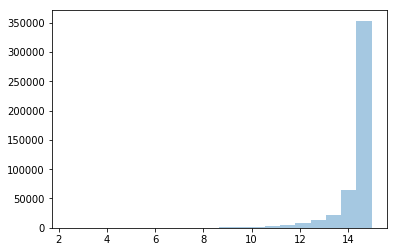

In [ ]:
sns.distplot(vectorizer.idf_, kde=False, bins=20)

## Calculate Cosine Similarity Matrix

After we vectorized the company names we can calculate the cosine similarity between each company name in the two datasets.

The resulting cosine similarity matrix has massive size(28k to 2 million). To be able to store it in the memory we selected candidates that have a cosine similarity larger than a given threshould and we stored the result in a sparse matrix to eliminate zeros. 

In [12]:
THRES = 0.4
cosine_similarities, max_similarities = matrix_ops.get_cosine_similarities(tfidf, tfidf_USA, THRES)

/Users/hakansirin/Desktop/idp-ws19/src/matrix_ops.py:23: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  cosine_similarities[batch_start:batch_end] = cos_sim_sparse


0 of 28816 documents are calculated
1000 of 28816 documents are calculated
2000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated
11000 of 28816 documents are calculated
12000 of 28816 documents are calculated
13000 of 28816 documents are calculated
14000 of 28816 documents are calculated
15000 of 28816 documents are calculated
16000 of 28816 documents are calculated
17000 of 28816 documents are calculated
18000 of 28816 documents are calculated
19000 of 28816 documents are calculated
20000 of 28816 documents are calculated
21000 of 28816 documents are calculated
22000 of 28816 documents are calculated
23000 of 28816 documents are calculated
24000 of 28816 documents are calculated
25000 of 2881

### Load cosine similarity matrix

In [ ]:
cosine_similarities  = sparse.load_npz('cosine_similarities.npz')
max_similarities = np.load('max_similarities.npy')
cosine_similarities

<28816x2318211 sparse matrix of type '<class 'numpy.float64'>'
	with 4774116 stored elements in Compressed Sparse Row format>

## Selection of the best Candidates
After calculating the cosine similarity between the companies, we end up on avarege 200 candidate for each company in the CFMCF dataset.
In our selection of the best candidate we intruduce a bonus point on top of the cosine_similarity measure.
The default bonuses that we selected are as:
- same state bonus = 0.1
- same country bonus = 0.1
- same address bonus = 0.3

Afterwards the selection of the best candidate is done using this combined score metric.

In [ ]:
best_matches = matrix_ops.get_best_candidates(chair_df, usa_df, cosine_similarities, companies, 
                                              zip_bonus = 0.1, state_bonus=0.1, address_bonus= 0.3 )

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/Users/hakansirin/Desktop/idp-ws19/src/matrix_ops.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['cos_sim'] = expanded_cos_sims
/Users/hakansirin/Desktop/idp-ws19/src/matrix_ops.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['cos_sim'] = candi

0 of 28816 documents are calculated


/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


1000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated
11000 of 28816 documents are calculated
12000 of 28816 documents are calculated
13000 of 28816 documents are calculated
14000 of 28816 documents are calculated
15000 of 28816 documents are calculated
16000 of 28816 documents are calculated
17000 of 28816 documents are calculated
18000 of 28816 documents are calculated
19000 of 28816 documents are calculated


In [ ]:
chair_df.notnull().sum()

In [ ]:
best_matches.dropna(how='all')[['conm','cleaned','recipient_name','clean_recipient_name','cos_sim','score']]

In [ ]:
best_matches

## all data 

In [ ]:
cos_sims

In [ ]:
cos_sims = best_matches.cos_sim.dropna().astype('float')
sns.distplot(cos_sims, kde=False, bins=20)
print((sum(cos_sims > 0.8), sum(cos_sims == 1), cos_sims.shape))

In [ ]:
scores = best_matches.score.dropna().astype('float')
sns.distplot(scores, kde=False, bins=20)
print((sum(cos_sims > 0.8), sum(cos_sims == 1), cos_sims.shape))

In [ ]:
sns.distplot(values, kde=False, bins=20)
print((sum(values > 0.8), sum(values == 1), values.shape))

In [ ]:
# sum(values >= 0.6)

# Match results

In [ ]:
vectorizer.vocabulary_, len(vectorizer.vocabulary_)